In [1]:
import tempfile

import torch
import yaml
import mlflow
import polars as pl
import numpy as np
from captum.attr import IntegratedGradients
import seaborn as sns

from src.data import PretrainingDataset
from src.net import RogersNet, LinearProbeNet

In [2]:
# Setup -------------------------

# Load config
with open("./cfg/testing_config.yaml", "r") as f:
    config = yaml.load(f, Loader=yaml.CLoader)

ms = config["model_source"]

# Set a seed
torch.manual_seed(config["split_seed"])

# Can I use the tensor cores?
torch.set_float32_matmul_precision("medium")

# Set mlflow uri: expecting local server
mlflow.set_tracking_uri(uri="http://127.0.0.1:8081")

# Get the main model checkpoint from mlflow ---------------

with tempfile.TemporaryDirectory() as temp_dir:
    # Model checkpoint
    ckpt_base_path = mlflow.artifacts.download_artifacts(
        run_id=ms["run_id"],
        artifact_path=f"model/checkpoints/{ms['checkpoint_name']}",
        dst_path=temp_dir,
    )
    ckpt_path = f"{ckpt_base_path}/{ms['checkpoint_name']}.ckpt"

    net = RogersNet.load_from_checkpoint(
        checkpoint_path=ckpt_path,
    )
    morpher_states = {feat: m.save_state_dict() for feat, m in net.morphers.items()}

# Get the linear probe model checkpoint from mlflow -----------
lps = config["linear_probe_source"]

with tempfile.TemporaryDirectory() as temp_dir:
    # Model checkpoint
    ckpt_base_path = mlflow.artifacts.download_artifacts(
        run_id=lps["run_id"],
        artifact_path=f"model/checkpoints/{lps['checkpoint_name']}",
        dst_path=temp_dir,
    )
    ckpt_path = f"{ckpt_base_path}/{lps['checkpoint_name']}.ckpt"

    lp_net = LinearProbeNet.load_from_checkpoint(
        checkpoint_path=ckpt_path,
    )

In [3]:
# Create a dataset ---------------

extra_cols = ["pitch_type"]

ds = PretrainingDataset(
    parquet_path=config["train_data_path"],
    cols=config["features"],
    key_cols=config["keys"],
    aux_cols=["pitch_type"],
    morpher_states=morpher_states,
    morpher_dispatch=config["morpher_dispatch"],
)

# TKTK Actually get consistent splits.
_, _, test_ds = torch.utils.data.random_split(ds, lengths=[0.75, 0.15, 0.1])

test_dl = torch.utils.data.DataLoader(
    dataset=test_ds,
    batch_size=2048,
    num_workers=10,
    shuffle=True,
)

In [4]:
# This depends on the two networks loaded above. 
# TKTK a class to do this.
def explainable_forward(x):
    # We've already applied the embedding layer.

    # From the base network
    x = net.feature_norm(x)
    normed_cls = net.feature_norm(net.cls)
    x = net.positional_encoding(x)
    x = torch.cat([x, normed_cls.expand([x.shape[0], -1, -1])], dim=1)
    x = net.transformer(x)
    x = net.projection_head(x[:, -1, :])

    # From the linear probe
    return lp_net(x)

In [5]:
# Lazily set some options.
target_pitch_type = "FF"
multiply_by_inputs = True
n_dataloader_batches = 1
explain_batch_size = 32

input_cols = list(net.embedding_layer.embedding_layers.keys())

# First let's get some inputs
smooth_inputs = []
raw_inputs = {
    ic: list() for ic in input_cols
}
is_target = []
with torch.no_grad():
    for i, batch in enumerate(test_dl):

        # Move the inputs
        x = {
            k: v.to(net.device)
            for k, v in batch.items() if isinstance(v, torch.Tensor)
        }
        # Also store the raw inputs
        for k, v in x.items():
            # Handle RankScaler inputs
            if len(v.shape) == 2:
                raw_inputs[k].append(v[:, 0])
            else:
                raw_inputs[k].append(v)
        # Store the target
        is_target += [pt == target_pitch_type for pt in batch["pitch_type"]]
        smooth_inputs.append(net.embedding_layer(x))
    
        if i == n_dataloader_batches - 1:
            break

smooth_inputs = torch.cat(smooth_inputs, dim=0)
baseline = smooth_inputs.mean(dim=0, keepdim=True)

raw_inputs = {
    k: torch.cat(v, dim=0).cpu().numpy() for k, v in raw_inputs.items()
}

shap = IntegratedGradients(
    explainable_forward,
    multiply_by_inputs=multiply_by_inputs
)

In [6]:
# We need to operate on very small batches because this uses 
# so, so much gpu memory.
# This is not super fast, either.

logits = []
per_column_attributions = []

for i in range(smooth_inputs.shape[0] // explain_batch_size):

    x = smooth_inputs[(i * explain_batch_size):((i + 1) * explain_batch_size)]

    logits.append(explainable_forward(x).detach().cpu().numpy())
    
    attributions = shap.attribute(
        inputs=x,
        baselines=baseline,
        n_steps=200,  # Again, what's a good value...
        target=0,
    )
    per_column_attributions.append(attributions.sum(dim=-1).detach().cpu().numpy())

# Combine stuff
logits = np.concatenate(logits, axis=0)[:, 0]
per_column_attributions = np.concatenate(per_column_attributions, axis=0)

In [7]:
result_df = pl.DataFrame(
    {
        "id": np.arange(len(is_target)),
        "is_slider": is_target,
        "prediction": (1 + np.exp(-logits)) ** -1,
        "attribution_implied_pred": (1 + np.exp(-per_column_attributions.sum(axis=-1))) ** -1,
    } | {
        input_col: per_column_attributions[:, i]
        for i, input_col in enumerate(input_cols)
    }
)
raw_inputs_df = pl.DataFrame(
    {
        "id": np.arange(len(is_target)),
    } | {
        input_col: raw_inputs[input_col]
        for input_col in input_cols
    }
)

In [8]:
# Mean absolute integrated gradients
importance = (
    result_df.select(
        **{
            i_col: pl.col(i_col).abs().mean()
            for i_col in input_cols
        }
    )
    .melt(id_vars=[])
    .sort("value", descending=True)
)
importance_order = importance["variable"].to_numpy()
importance

variable,value
str,f64
"""pfx_z""",1.973759
"""spin_axis""",0.936466
"""release_spin_r…",0.884552
"""pfx_x""",0.499644
"""release_speed""",0.398107
"""release_pos_x""",0.371539
"""plate_z""",0.26912
"""p_throws""",0.250119
"""release_pos_z""",0.164714


<Axes: xlabel='attribution', ylabel='variable'>

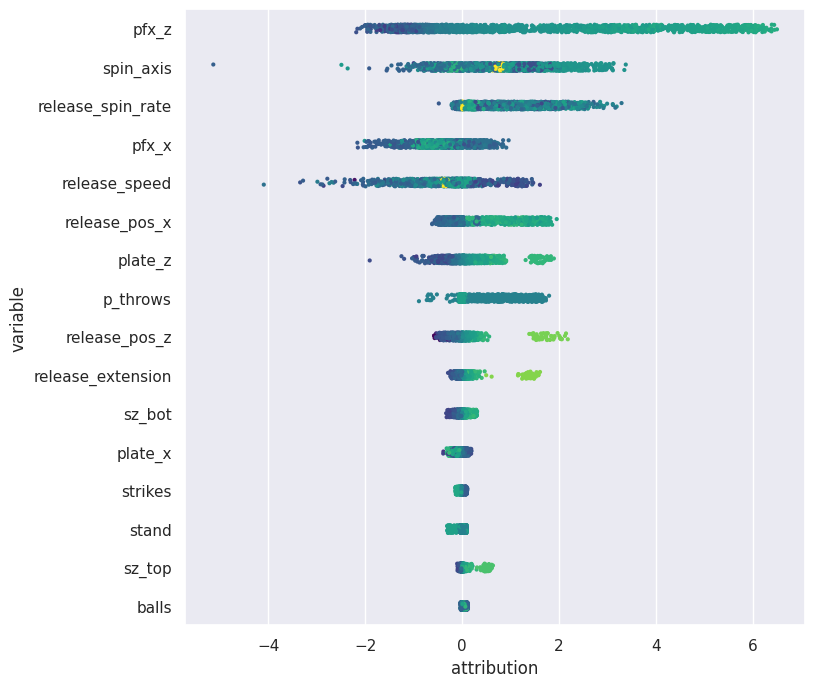

In [9]:
# Plot them with a shap-style strip plot.
attribution_df = (
    result_df.select(["id"] + input_cols)
    .melt(id_vars=["id"], value_name="attribution")
)
raw_value_df = raw_inputs_df.melt(id_vars=["id"])
combined_df = attribution_df.join(raw_value_df, on=["id", "variable"])
combined_df = combined_df.with_columns(
    # This is a nonsense transformation, to be clear.
    # It's just to fix a problem with color mapping on this messed-up data.
    color=pl.col("value").sign() * (1 + pl.col("value").abs()).log().clip(0, 3)
)

sns.set(rc={'figure.figsize':(8,8)})
sns.stripplot(
    data=combined_df,
    x="attribution",
    y="variable",
    hue="color",
    order=importance_order,
    size=3,
    legend=None,
    palette="viridis",
)